In [166]:
%load_ext autoreload
%autoreload 2

[autoreload of tigerml.reports.html.contents.HTMLImage failed: Traceback (most recent call last):
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "D:\miniconda\envs\tigerml-fix\lib\site-packages\IPython\extensions\autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new,

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Sample Template for Sales data using code templates Regression

## Imports

In [137]:
%%time
import warnings
warnings.filterwarnings('ignore')
import yaml
import sys
import os
import numpy as np
# adding the path to the scripts to sys
sys.path.append(os.path.join(os.getcwd(),"../.." ))
import utils
from data_processing import DataPrep, MiceImputer,Encoder,DataProcessor,Imputer,date_features
from data_processing import tiger_dataframe as td
from data_processing import string_cleaning,clean_col_names
from eda import Analyser,DataExplorer,CorrelationTable
import eda
import model_gen as mg
import model_eval as me
from feature_selection import FeatureSelector

Wall time: 0 ns


##### Config Read

In [117]:
cfg = utils.load_yml("config.yml")

In [118]:
cfg

{'data': {'input': {'path': './data/sales data sample.csv',
   'target_column': 'UnitPrice'},
  'outlier': {'handle': False,
   'remove': None,
   'impute': 'mean',
   'inf_is_outlier': False},
  'imputation': {'drop': False, 'numerical': 'knn', 'categorical': None},
  'encode_non_numeric': True,
  'train_test_split': {'shuffle': True,
   'train': 0.7,
   'test': 0.2,
   'validation': 0.1,
   'random_state': 11}},
 'fs': 'recursion',
 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5}},
  'recursion': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5},
   'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}},
 'models': {'ridge': {'estimator': 'sklearn.linear_model.Ridge',
   'params': {'alpha': [5, 0.5]}},
  'lasso': {'estimator': 'sklearn.linear_model.Lasso',
   'params': {'alpha': [5, 0.5]}},
  'rf': {'estimator': 'sklearn.ensemble.RandomForestRegressor',
   'par

## Data Read (Into a Tiger Dataframe(Wrapper around the generic Pandas DF))

In [119]:
df = td.read_csv(path=cfg['data']['input']['path'])
df_copy=df.copy()

In [98]:
df.head()

### Converting the date, str columns to proper datatype
1. businessunit are the place where products are manufactured
2. Line is the Shipment line, So converting numbers to string

In [120]:
df = df.convert_datetimes()
df['BusinessUnit']=df['BusinessUnit'].astype(str)
df['Line']=df['Line'].astype(str)

### Data Health Report Generation

In [9]:
an = Analyser(data=df)
an.health_analysis(save_as='.html')

Started running health_analysis
Started running data_health
Started running duplicate_columns
processing set of - ['color', 'RS_Color']
Finished running data_health
Time taken to run data_health is 2 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 1 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 1 seconds


"Cannot compute health_analysis. Error - 'EDAReport' object has no attribute 'duplicate_columns_result'"

#### Summary of variables

In [126]:
an.variable_summary()

Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 1 seconds


#### summary of missing values

In [127]:
an.missing_value_summary()

Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 14 seconds


index     Variable Name  No of Missing  Per of Missing
0     26          RS_Color            309        0.176760
1     27    RS_ModelFamily             87        0.049767
2     28          RS_Grade              1        0.000572
3     29  FunctionalStatus              1        0.000572
4     30     RS_memorySize          14006        8.011990
5     31          RS_Brand             28        0.016017

#### Feature Analysis and Interactions

In [52]:
an.feature_analysis(save_as=".html")

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 6 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 2 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 6 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 1 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 16 seconds
Started running feature_normality


p-value may not be accurate for N > 5000.


Finished running feature_normality
Time taken to run feature_normality is 0 seconds
Finished running feature_analysis
Time taken to run feature_analysis is 64 seconds


{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1fa28890400>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1fa1d42e0d0>]},
 'distributions': {'numeric_variables': {'BusinessUnit': [:Layout
       .Distribution.I :Distribution   [BusinessUnit]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.BusinessUnit :Bars   [index]   (BusinessUnit)
       .Table.I           :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II          :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'ExtCost': [:Layout
       .Distribution.I :Distribution   [ExtCost]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.ExtCost :Bars   [index]   (ExtCost)
       .Table.I      :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II     :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'ExtPrice': [:Layout
       .Distribution.I :Distribution   [ExtPrice

Looking at the Basic EDA like min, max mean and so,
1. The varables ExtCost,ExtPrice,GP are having extreme -ve values and extreme +ve values(Outlier treatment is required)
2. Unit Cost has outliers

### Getting the numerical columns, categorical columns and date_columns

In [121]:
dp = DataProcessor(data=df, y=cfg['data']['input']['target_column'])
dp.get_numeric_columns(), dp.get_cat_columns(), dp.get_dt_columns(), #dp.get_x_cols()

(['ExtCost',
  'ExtPrice',
  'GP',
  'InvoiceNumber',
  'Orderno',
  'QtyShipped',
  'UnitCost',
  'UnitPrice'],
 ['BusinessUnit',
  'CHANNEL_REPORTING',
  'Carrier',
  'Customername',
  'FunctionalStatus',
  'InvtID',
  'Line',
  'LocOrUnLoc',
  'MDM_SourceChannel',
  'ManufSRP2',
  'MemorySize',
  'ModelFamily',
  'OrderType',
  'Platforms',
  'RS_Brand',
  'RS_Color',
  'RS_Grade',
  'RS_ModelFamily',
  'RS_memorySize',
  'SKuDescription',
  'SalesPerson',
  'StockCondition',
  'Technology',
  'color'],
 ['GLDate'])

### Performing a String cleaning as the values have space at the end

In [122]:
for cat_col in dp.get_cat_columns():
    df[cat_col]=string_cleaning(df[cat_col])

### Cleaning Column Names

In [123]:
df.columns=clean_col_names(df.columns,lower=True)

In [124]:
df.columns

Index(['channel_reporting', 'gldate', 'invoicenumber', 'customername',
       'orderno', 'ordertype', 'salesperson', 'invtid', 'skudescription',
       'businessunit', 'line', 'manufsrp2', 'platforms', 'carrier',
       'locorunloc', 'qtyshipped', 'unitcost', 'unitprice', 'extprice',
       'extcost', 'gp', 'modelfamily', 'stockcondition', 'color', 'memorysize',
       'technology', 'rs_color', 'rs_modelfamily', 'rs_grade',
       'functionalstatus', 'rs_memorysize', 'rs_brand', 'mdm_sourcechannel'],
      dtype='object')

In [125]:
cfg['data']['input']['target_column']='unitprice'

### Finding Duplicate Variables
1. target encoding all the columns, so that if numerical and categorical column are have same value, can be regarded as duplicate

In [15]:
df_target_encoded,dup_columns=eda.check_duplicate_column(df,dv_name=cfg['data']['input']['target_column'],drop_na=False)

There are no duplicate columns


2. Finding correlation between X variables with a threshhold of 0.95
if greater than 0.95 then the variables are considered as duplicates

In [66]:
corr_table=CorrelationTable(df_target_encoded)
x_corr_table=corr_table.get_plot()

In [67]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174813 entries, 0 to 174812
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CHANNEL_REPORTING  174813 non-null  object 
 1   GLDate             174813 non-null  object 
 2   InvoiceNumber      174813 non-null  int64  
 3   Customername       174813 non-null  object 
 4   Orderno            174813 non-null  int64  
 5   OrderType          174813 non-null  object 
 6   SalesPerson        174813 non-null  object 
 7   InvtID             174813 non-null  object 
 8   SKuDescription     174813 non-null  object 
 9   BusinessUnit       174813 non-null  int64  
 10  Line               174813 non-null  int64  
 11  ManufSRP2          174813 non-null  object 
 12  Platforms          174813 non-null  object 
 13  Carrier            174813 non-null  object 
 14  LocOrUnLoc         174813 non-null  object 
 15  QtyShipped         174813 non-null  int64  
 16  Un

In [68]:
corr_table.get_plot()[corr_table.get_plot()['Coer Coef']>0.95]

Variable 1         Variable 2  Coer Coef  Abs Coer Coef
0      invoicenumber            orderno   0.998290       0.998290
1             invtid     skudescription   0.997251       0.997251
2              color           rs_color   0.997038       0.997038
3          manufsrp2           rs_brand   0.995192       0.995192
4        modelfamily     rs_modelfamily   0.984036       0.984036
5         memorysize      rs_memorysize   0.983874       0.983874
6             invtid          unitprice   0.974352       0.974352
7     skudescription          unitprice   0.973539       0.973539
8  channel_reporting  mdm_sourcechannel   0.966713       0.966713
9           rs_grade     stockcondition   0.959515       0.959515

1. As each OrderNo has one InvoiceNumber, both the variables can be disregarded
<br />
2. Each InvtID has a Stock Keeping Unit(SKU) description and either of them are highly correlated with the UnitPrice,\
we can have one variable(InvtID)
<br />
3. RS_Color and color are similar type of variable, which denote the color of the product
<br />
4. ManufSRP2, RS_Brand are similar type of variables, which denote the brand of the product and former is an abbrevation name
<br />
5. ModelFamily,RS_ModelFamily are similar variables, ModelFamily has specs(864GB) of the products as name and RS_ModelFamily has name(IPHONE 8) of the product
<br />
6. MemorySize,RS_memorySize are duplicate variables, both denote the same value mostly
<br />
7. Though CHANNEL_REPORTING,MDM_SourceChannel are highly correlated, seems Channel Reporting has detailed source where as MDM_SourceChannel has a top level info
<br />
8. RS_Grade, StockCondition both denote the similar state of the Stocks, RS_Grade has proper naming convention, but StockCondition has abbrevated names and duplicates so cleaning of Stock Condition is required
<br />
Basis on the above statements, the following columns are ignored:
    OrderNo,InvoiceNumber,SKuDescription,RS_Color,RS_Brand,RS_ModelFamily,RS_memorySize,MDM_SourceChannel,StockCondition

Also,one of the column is Customer Name and GLDate is a date column so ignoring them too

We will add DateFeatures from GLData

In [126]:
df_copy=df.copy()

In [127]:
ignore_cols=['customername','gldate','orderno','invoicenumber','skudescription','rs_color','rs_brand','rs_modelfamily','rs_memorysize','mdm_sourcechannel','stockcondition']

In [128]:
df_copy=df_copy[set(df_copy.columns)-set(ignore_cols)]

### Again generating feature generation report to see the values post cleaning

In [114]:
an = Analyser(data=df_copy,)
an.feature_analysis(save_as=".html")

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 4 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 2 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 4 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 1 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 9 seconds
Started running feature_normality
Finished running feature_normality
Time taken to run feature_normality is 0 seconds
Finished running 

{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x281b8cdefa0>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x281ff7689d0>]},
 'distributions': {'numeric_variables': {'days_since_last_purchase': [:Layout
       .Distribution.I :Distribution   [days_since_last_purchase]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Days_since_last_purchase :Bars   [index]   (days_since_last_purchase)
       .Table.I                       :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II                      :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'extcost': [:Layout
       .Distribution.I :Distribution   [extcost]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Extcost :Bars   [index]   (extcost)
       .Table.I      :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II     :Table   [99%,99.2%,99.4%,99.6%,99.8%]],


https://drive.google.com/file/d/1rtwsrrE7GDVQ1i8K0abh_4ZdKBw7znHN/view?usp=sharing

### Impute NAN to missing values
1. Platforms,LocOrUnLoc has empty string which should be treated as missing values so explicitly converting them to NA
2. Carrier has 0 as one of the value where the variable is a string

In [129]:
df['platforms']=df['platforms'].apply(lambda x: np.nan if str(x)=='' else x)
df['locorunloc']=df['locorunloc'].apply(lambda x: np.nan if str(x)=='' else x)
df['technology']=df['technology'].apply(lambda x: np.nan if str(x)=='NA' else x)

df_copy['platforms']=df_copy['platforms'].apply(lambda x: np.nan if str(x)=='' else x)
df_copy['locorunloc']=df_copy['locorunloc'].apply(lambda x: np.nan if str(x)=='' else x)
df_copy['technology']=df_copy['technology'].apply(lambda x: np.nan if str(x)=='NA' else x)

In [131]:
df_copy_2=df_copy.copy()

#### Feature Interactions

In [77]:
an = Analyser(data=df_copy_2)
an.feature_interactions(save_as=".html")

Started running feature_interactions
Started running preprocess_data
Cleaning data
Imputing missing values with median for numeric data and mode for categorical data.
There are 1 missing values in the variable - rs_grade
All missing values are imputed with mode
There are 1 missing values in the variable - functionalstatus
All missing values are imputed with mode
There are 29106 missing values in the variable - platforms
All missing values are imputed with mode
There are 11150 missing values in the variable - technology
All missing values are imputed with mode
There are 199 missing values in the variable - locorunloc
All missing values are imputed with mode
No Infinity values
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
CANNOT ENCODE invtid. A good encoding method is not found.
CANNOT ENCODE line. A good encoding method is not found.
CANNOT ENCODE platforms. A good encoding method is not found.
C

{'correlation_table': [                                Variable 1                      Variable 2  \
  0      onehot_encoded_businessunit_6160922  onehot_encoded_salesperson_DCO   
  1            onehot_encoded_locorunloc_LKD   onehot_encoded_locorunloc_ULD   
  2     onehot_encoded_channel_reporting_CPO     onehot_encoded_rs_grade_CPO   
  3      onehot_encoded_businessunit_6219904     onehot_encoded_ordertype_CR   
  4              onehot_encoded_ordertype_CR     onehot_encoded_ordertype_SO   
  ...                                    ...                             ...   
  7621   onehot_encoded_businessunit_6160922    onehot_encoded_manufsrp2_ALC   
  7622       onehot_encoded_memorysize_512GB  onehot_encoded_salesperson_BST   
  7623   onehot_encoded_businessunit_6119904    onehot_encoded_carrier_BOOST   
  7624          onehot_encoded_carrier_BOOST    onehot_encoded_manufsrp2_ALC   
  7625   onehot_encoded_businessunit_6119904    onehot_encoded_manufsrp2_ALC   
  
        Coer Coe

https://drive.google.com/file/d/1rtwsrrE7GDVQ1i8K0abh_4ZdKBw7znHN/view?usp=sharing

### Missing data in columns

In [133]:
df_missing=df_copy.isna().sum()._data
df_missing[df_missing>0]

rs_grade                1
platforms           29106
technology          11150
functionalstatus        1
locorunloc            199
dtype: int64

Based on the Above Analysis, 
1. FunctionalStatus,RS_Grade has only 1 missing value, so mode is chosen
2. Platforms has 29106 and LocOrUnLoc has 199,technology has 11150 so constant Missing is imputed


#### Key Features

Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
color has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
memorysize has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
manufsrp2 has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
ordertype has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
technology has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
salesperson has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
invtid has levels with less than 3496 (2.0%) values. Target encoding in such cases is not recommended.
line has levels with less than 3496 (2.0%

{'unitprice': {'feature_scores': {'feature_correlation': :Bars   [index]   (Pearson_correlation_with_Target)},
  'feature_importances': "Cannot compute feature_importances. Error - 'LogisticRegression' object has no attribute 'feature_importances_'",
  'pca_analysis': "Cannot compute get_pca_analysis. Error - 'DataFrame' object has no attribute 'fit_transform'"}}

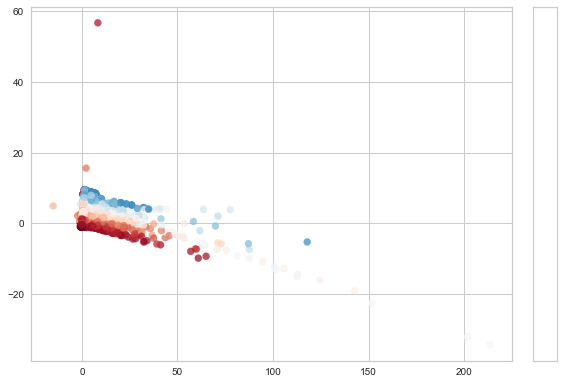

In [79]:
an = Analyser(data=df_copy)
an.key_drivers(save_as=".html", y=cfg['data']['input']['target_column'])

https://drive.google.com/file/d/1rtwsrrE7GDVQ1i8K0abh_4ZdKBw7znHN/view?usp=sharing

### The Keydrivers plot only had the Feature Correlation with Numerical variables

PCA plots are not generated in the htmls

#### Visualiser for Data (Furthermore, any other EDA or this can be got from the visualiser and summarised in story boarding)

In [15]:
df = df.categorize()
de = DataExplorer(df)
de.open(port=1006)

Launching server at http://localhost:1006


A visualiser shold have opened up in the above url

## Data Processing for Modelling


## Adding features like first time customer, days since last purchse, Date features

1. first time customer
2. days between puchases

In [134]:
customer_details=df['customername'].value_counts()
cust_df=td.DataFrame(customer_details.index,columns=['customername'])
cust_df['values']=customer_details.values
cust_df['firsttime_customer']=np.where(cust_df['values']==1,1,0)
cust_df.drop('values',axis=1,inplace=True)

df=df.merge(cust_df,on='customername')

In [135]:
#### 2. days since last purchase
df.sort_values('gldate',inplace=True)
df['days_since_last_purchase'] = (
    df
       .groupby(df['customername'])['gldate']
       .diff()
       .dt.days
       .fillna(0, downcast='infer'))

In [138]:
df=date_features(df,date_col=dp.get_dt_columns()[0])

In [139]:
ignore_cols=['customername','gldate','orderno','invoicenumber','skudescription','rs_color','rs_brand','rs_modelfamily','rs_memorysize','mdm_sourcechannel','stockcondition']

In [140]:
df=df[list(set(df.columns)-set(ignore_cols))]

#### obtaining target and x_vars

In [142]:
target=cfg['data']['input']['target_column']
x_cols=list(set(df.columns)-set(ignore_cols))

### Imputing the Categorical columns

#### Missing data in columns

In [143]:
df_missing=df.isna().sum()._data
df_missing[df_missing>0]

rs_grade                1
platforms           29106
technology          11150
functionalstatus        1
locorunloc            199
dtype: int64

Based on the Above Analysis, 
1. FunctionalStatus,RS_Grade has only 1 missing value, so mode is chosen
2. Platforms has 29106 and LocOrUnLoc has 199, technology has 11150 so constant Missing is imputed

In [144]:
imp = Imputer(df)
imp.add_imputation_rule(cols=['functionalstatus','rs_grade'],impute_method='mode')
imp.add_imputation_rule(cols=['platforms','locorunloc','technology'],impute_method='constant')
df_imputed=imp.transform()

There are 1 missing values in the variable - functionalstatus
All missing values are imputed with mode
There are 1 missing values in the variable - rs_grade
All missing values are imputed with mode
There are 29106 missing values in the variable - platforms
All missing values are imputed with Missing
There are 199 missing values in the variable - locorunloc
All missing values are imputed with Missing
There are 11150 missing values in the variable - technology
All missing values are imputed with Missing


### Encoding Categorical X Features
1. Performing target encoding for categorical variable with high cardinality
2. Onehot encoding for low cardinality variables

In [145]:
dp=DataProcessor(df,y=cfg['data']['input']['target_column'])
dp.get_cat_columns()

['businessunit',
 'carrier',
 'channel_reporting',
 'color',
 'functionalstatus',
 'invtid',
 'line',
 'locorunloc',
 'manufsrp2',
 'memorysize',
 'modelfamily',
 'ordertype',
 'platforms',
 'rs_grade',
 'salesperson',
 'technology']

In [146]:
df_copy=df.copy()

#### getting the variable summary again

In [86]:
an = Analyser(data=df_copy[dp.get_cat_columns()])
an.health_analysis(save_as='.html')
an.variable_summary()

Started running health_analysis
Started running data_health
Started running duplicate_columns
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Variable name mismatch
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds


Basis on above table
1. Target encoding businessunit,channel_reporting,carrier,invtid,line,manufsrp2,memorysize,modelfamily,platforms,rs_grade,salesperson,color
2. Onehot encoding ordertype,technology,locorunloc,functionalstatus,

#### Performing encoding

In [147]:
target_encoding=['businessunit', 'channel_reporting', 'carrier', 'invtid', 'line', 'manufsrp2', 'memorysize', 'modelfamily', 'platforms', 'rs_grade', 'salesperson', 'color']
ohe_encoding=['ordertype', 'technology', 'locorunloc', 'functionalstatus']
en = Encoder(df_imputed, y=cfg['data']['input']['target_column'])
en = en.add_encode_rule(cols=target_encoding, method='target')
df_encoded = en.transform()

In [148]:
en = Encoder(df_encoded, y=cfg['data']['input']['target_column'])
en = en.add_encode_rule(cols=ohe_encoding, method='onehot')
df_encoded = en.transform()

Encoding 4 columns. Columns - ['carrier', 'modelfamily', 'rs_grade', 'platforms', 'line', 'invtid', 'memorysize', 'businessunit', 'color', 'channel_reporting', 'manufsrp2', 'salesperson'] are already encoded.


#### dropping encoded columns

In [149]:
df_encoded.drop(target_encoding+ohe_encoding,axis=1,inplace=True)

In [150]:
df_encoded.columns

Index(['extcost', 'days_since_last_purchase', 'extprice', 'wom', 'qtyshipped',
       'unitcost', 'gp', 'week_day_num', 'firsttime_customer',
       'target_encoded_businessunit', 'target_encoded_channel_reporting',
       'target_encoded_carrier', 'target_encoded_invtid',
       'target_encoded_line', 'target_encoded_manufsrp2',
       'target_encoded_memorysize', 'target_encoded_modelfamily',
       'target_encoded_platforms', 'target_encoded_rs_grade',
       'target_encoded_salesperson', 'target_encoded_color',
       'onehot_encoded_ordertype_CR', 'onehot_encoded_ordertype_S1',
       'onehot_encoded_ordertype_SO', 'onehot_encoded_ordertype_SP',
       'onehot_encoded_technology_CDM', 'onehot_encoded_technology_GSM',
       'onehot_encoded_technology_LTE', 'onehot_encoded_technology_MM',
       'onehot_encoded_technology_Missing', 'onehot_encoded_technology_WFI',
       'onehot_encoded_locorunloc_LKD', 'onehot_encoded_locorunloc_Missing',
       'onehot_encoded_locorunloc_ULD',
  

### Data Preparation like outlier treatment, If NA values are to be dropped based on config
1. As 1st step not treating any outliers 
2. NA values are not dropped becausethey are imputed as Missing above
3. Train test split




In [151]:
data_prep=DataPrep(cfg)
data_prep.fit(df_encoded)
x_train, x_test, y_train, y_test = data_prep.transform(df_encoded)

In [152]:
x_train.head()

days_since_last_purchase    extcost  extprice  firsttime_customer  \
140525                         0  199040.00  230400.0                   0   
13813                          0    1207.49    1840.0                   0   
118067                         0      78.62      60.0                   0   
70838                          0    4024.46    6750.0                   0   
14662                          0     908.79     875.0                   0   

              gp  onehot_encoded_functionalstatus_REVIEW  \
140525  31360.00                                       0   
13813     632.51                                       0   
118067    -18.62                                       0   
70838    2725.54                                       0   
14662     -33.79                                       0   

        onehot_encoded_functionalstatus_TESTED  \
140525                                       1   
13813                                        0   
118067                                       0   
70838                                        0   
14662                                        0   

        onehot_encoded_functionalstatus_UNTESTED  \
140525                                         0   
13813                                          1   
118067                                         1   
70838                                          1   
14662                                          1   

        onehot_encoded_locorunloc_LKD  onehot_encoded_locorunloc_Missing  ...  \
140525                              0                                  0  ...   
13813                               0                                  0  ...   
118067                              0                                  0  ...   
70838                               0                                  0  ...   
14662                               0                                  0  ...   

        target_encoded_line  target_encoded_manufsrp2  \
140525           124.622766                138.125668   
13813            120.734250                138.125668   
118067           122.668539                138.125668   
70838            154.021125                138.125668   
14662            123.144286                138.125668   

        target_encoded_memorysize  target_encoded_modelfamily  \
140525                 155.540247                  359.210969   
13813                  155.540247                   83.730037   
118067                 110.567364                   91.162621   
70838                  179.445813                  181.395000   
14662                   72.218123                  121.621290   

        target_encoded_platforms  target_encoded_rs_grade  \
140525                387.645124               333.132836   
13813                  78.981624               100.684386   
118067                 97.194256               100.684386   
70838                 161.450067               116.703945   
14662                 144.919652               116.703945   

        target_encoded_salesperson  unitcost  week_day_num  wom  
140525                  216.355494   311.000             4    4  
13813                   119.767349    52.499             5    1  
118067                  119.767349    78.618             5    4  
70838                   149.507461   134.148             4    4  
14662                   119.767349   129.826             1    1  

[5 rows x 37 columns]

## Feature selection 
1. Using Backward Selection to get important features and Ridge Regression is used

In [153]:
sel_=FeatureSelector(cfg)
sel_.fit(x_train,y_train)
x_train=sel_.transform(x_train)
x_test=sel_.transform(x_test)

selected features: ('days_since_last_purchase', 'gp', 'onehot_encoded_functionalstatus_TESTED', 'onehot_encoded_functionalstatus_UNTESTED', 'onehot_encoded_locorunloc_LKD', 'onehot_encoded_locorunloc_ULD', 'onehot_encoded_ordertype_S1', 'onehot_encoded_ordertype_SO', 'onehot_encoded_ordertype_SP', 'onehot_encoded_technology_CDM', 'onehot_encoded_technology_GSM', 'onehot_encoded_technology_MM', 'onehot_encoded_technology_Missing', 'onehot_encoded_technology_WFI', 'target_encoded_carrier', 'target_encoded_channel_reporting', 'target_encoded_color', 'target_encoded_invtid', 'target_encoded_line', 'target_encoded_manufsrp2', 'target_encoded_memorysize', 'target_encoded_modelfamily', 'target_encoded_platforms', 'target_encoded_rs_grade', 'target_encoded_salesperson', 'unitcost', 'week_day_num', 'wom')



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

### VIF Analysis

In [154]:
vif_df=mg.calc_vif(x_train)

In [155]:
vif_df

variables         VIF
0                   days_since_last_purchase    1.009224
1                                         gp    1.022834
2     onehot_encoded_functionalstatus_TESTED    4.430931
3   onehot_encoded_functionalstatus_UNTESTED   41.742613
4              onehot_encoded_locorunloc_LKD   12.230449
5              onehot_encoded_locorunloc_ULD  335.684479
6                onehot_encoded_ordertype_S1    1.007402
7                onehot_encoded_ordertype_SO   40.636533
8                onehot_encoded_ordertype_SP    1.003282
9              onehot_encoded_technology_CDM    2.413683
10             onehot_encoded_technology_GSM   34.528730
11              onehot_encoded_technology_MM   38.534480
12         onehot_encoded_technology_Missing    7.082548
13             onehot_encoded_technology_WFI   16.384670
14                    target_encoded_carrier  119.733939
15          target_encoded_channel_reporting   20.287594
16                      target_encoded_color   17.996413
17                     target_encoded_invtid   44.779054
18                       target_encoded_line   60.381033
19                  target_encoded_manufsrp2  110.423627
20                 target_encoded_memorysize    9.518727
21                target_encoded_modelfamily   65.484139
22                  target_encoded_platforms   33.845263
23                   target_encoded_rs_grade   18.874507
24                target_encoded_salesperson   31.676918
25                                  unitcost   12.631237
26                              week_day_num    5.055026
27                                       wom    5.470301

It is very much recommended to exclude variables that have VIF value greater than 10-15

### Modelling with OLS to see the coefficients

In [156]:
print_model=mg.load_linear_model(x_train,y_train)

In [157]:
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          2.370e+05
Date:                Tue, 04 Aug 2020   Prob (F-statistic):                        0.00
Time:                        14:12:26   Log-Likelihood:                     -5.5101e+05
No. Observations:              120378   AIC:                                  1.102e+06
Df Residuals:                  120350   BIC:                                  1.102e+06
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
days_since_last_purchase                     0.2083      0.020     10.585      0.000       0.170       0.247
gp                                           0.0001   8.83e-06     16.649      0.000       0.000       0.000
onehot_encoded_functionalstatus_TESTED       4.6905      0.525      8.926      0.000       3.661       5.720
onehot_encoded_functionalstatus_UNTESTED    11.2368      0.461     24.371      0.000      10.333      12.140
onehot_encoded_locorunloc_LKD              -21.9368      1.294    -16.951      0.000     -24.473     -19.400
onehot_encoded_locorunloc_ULD              -13.1415      1.265    -10.389      0.000     -15.621     -10.662
onehot_encoded_ordertype_S1                 17.6233     16.703      1.055      0.291     -15.115      50.361
onehot_encoded_ordertype_SO                -17.9225      0.438    -40.891      0.000     -18.782     -17.063
onehot_encoded_ordertype_SP                 -7.4442      8.335     -0.893      0.372     -23.780       8.891
onehot_encoded_technology_CDM                1.1402      0.848      1.345      0.179      -0.522       2.802
onehot_encoded_technology_GSM                2.5137      0.669      3.757      0.000       1.202       3.825
onehot_encoded_technology_MM                 3.5858      0.670      5.351      0.000       2.272       4.899
onehot_encoded_technology_Missing            4.9918      0.717      6.961      0.000       3.586       6.397
onehot_encoded_technology_WFI                3.3634      0.685      4.911      0.000       2.021       4.706
target_encoded_carrier                       0.0153      0.005      2.807      0.005       0.005       0.026
target_encoded_channel_reporting            -0.0109      0.002     -5.047      0.000      -0.015      -0.007
target_encoded_color                        -0.0151      0.002     -7.376      0.000      -0.019      -0.011
target_encoded_invtid                        0.7219      0.003    273.392      0.000       0.717       0.727
target_encoded_line                         -0.0625      0.004    -16.158      0.000      -0.070      -0.055
target_encoded_manufsrp2                     0.0459      0.005      8.753      0.000       0.036       0.056
target_encoded_memorysize                   -0.0056      0.001     -4.051      0.000      -0.008      -0.003
target_encoded_modelfamily                   0.2862      0.003     89.684      0.000       0.280       0.292
target_encoded_platforms                    -0.0599      0.002    -25.658      0.000      -0.064      -0.055
target_encoded_rs_grade                      0.1114      0.002     53.744      0.000       0.107       0.115
target_encoded_salesperson               

### Removing the variables having VIF> 10

In [158]:
vif_df[((vif_df.VIF<10))]

variables       VIF
0                 days_since_last_purchase  1.009224
1                                       gp  1.022834
2   onehot_encoded_functionalstatus_TESTED  4.430931
6              onehot_encoded_ordertype_S1  1.007402
8              onehot_encoded_ordertype_SP  1.003282
9            onehot_encoded_technology_CDM  2.413683
12       onehot_encoded_technology_Missing  7.082548
20               target_encoded_memorysize  9.518727
26                            week_day_num  5.055026
27                                     wom  5.470301

In [159]:
x_cols=list(set(vif_df[((vif_df.VIF<10))]['variables'].tolist()))+['target_encoded_invtid']

In [160]:
print_model=mg.load_linear_model(x_train[x_cols],y_train)
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          5.149e+05
Date:                Tue, 04 Aug 2020   Prob (F-statistic):                        0.00
Time:                        14:12:45   Log-Likelihood:                     -5.6036e+05
No. Observations:              120378   AIC:                                  1.121e+06
Df Residuals:                  120367   BIC:                                  1.121e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
onehot_encoded_ordertype_SP                2.5275      8.994      0.281      0.779     -15.100      20.155
target_encoded_memorysize                  0.0293      0.001     23.248      0.000       0.027       0.032
wom                                       -1.9138      0.044    -43.456      0.000      -2.000      -1.827
gp                                      7.096e-05   9.45e-06      7.507      0.000    5.24e-05    8.95e-05
days_since_last_purchase                   0.2340      0.021     11.024      0.000       0.192       0.276
onehot_encoded_functionalstatus_TESTED     0.5956      0.285      2.093      0.036       0.038       1.153
week_day_num                              -0.5649      0.035    -16.252      0.000      -0.633      -0.497
onehot_encoded_technology_CDM             -2.4732      0.596     -4.147      0.000      -3.642      -1.304
onehot_encoded_ordertype_S1               93.3563     17.989      5.190      0.000      58.099     128.614
onehot_encoded_technology_Missing          2.3927      0.301      7.950      0.000       1.803       2.983
target_encoded_invtid                      1.0243      0.001   1164.993      0.000       1.023       1.026
==============================================================================
Omnibus:                    39981.293   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12786070.350
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                      53.489   Cond. No.                     1.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Final x_cols


In [161]:
x_cols

['onehot_encoded_ordertype_SP',
 'target_encoded_memorysize',
 'wom',
 'gp',
 'days_since_last_purchase',
 'onehot_encoded_functionalstatus_TESTED',
 'week_day_num',
 'onehot_encoded_technology_CDM',
 'onehot_encoded_ordertype_S1',
 'onehot_encoded_technology_Missing',
 'target_encoded_invtid']

In [162]:
x_train=x_train[x_cols]
x_test=x_test[x_cols]

## Modelling

### List for Models to evaluate
1. Takes the config and generates a list of models along with grid search parameters

In [163]:
models = mg.list_models_from_config(cfg)

### Fit all the models and compare

In [164]:
report_comparison=me.RegressionComparison(models)

In [167]:
report_comparison.fit(x_train, y_train)

### Score all the models

In [168]:
report_comparison.score(x_test, y_test)

 99%|===================| 99/100 [03:14<00:01]        

### Get comparison Report

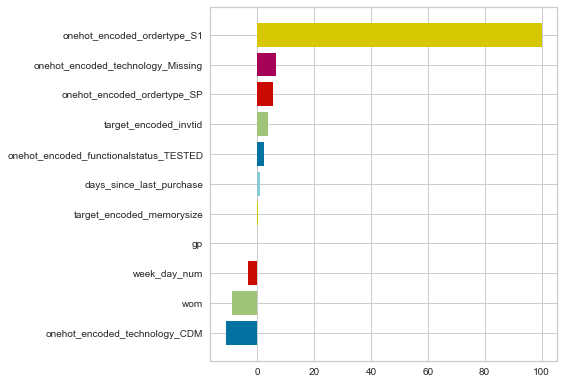

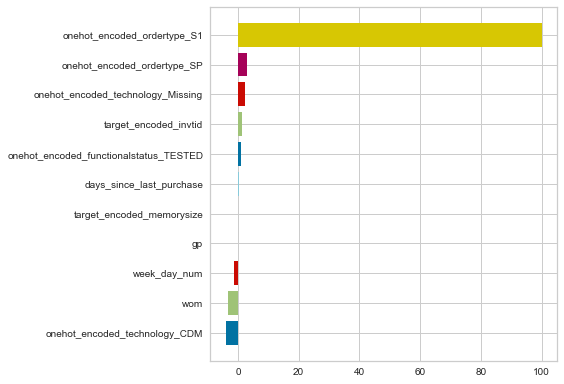

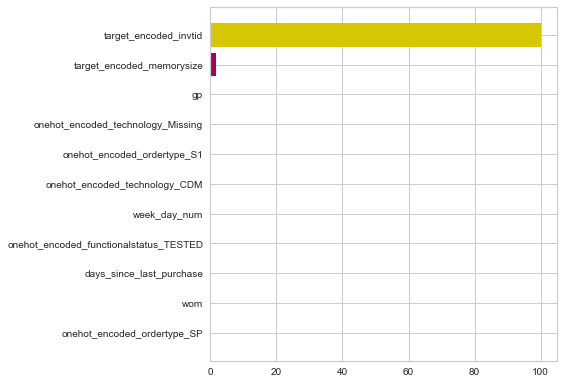

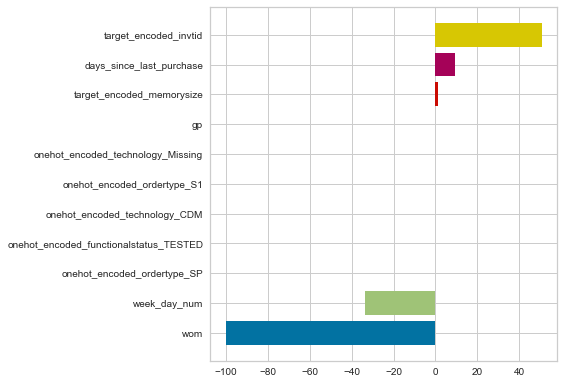

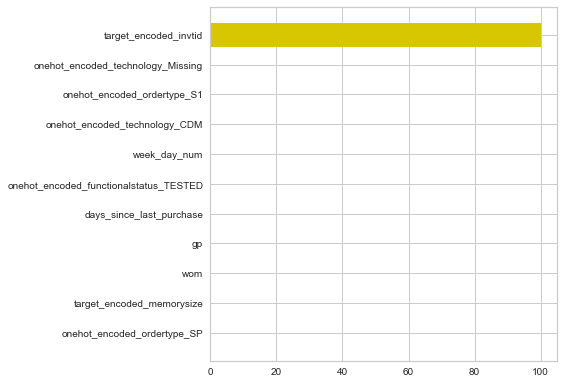

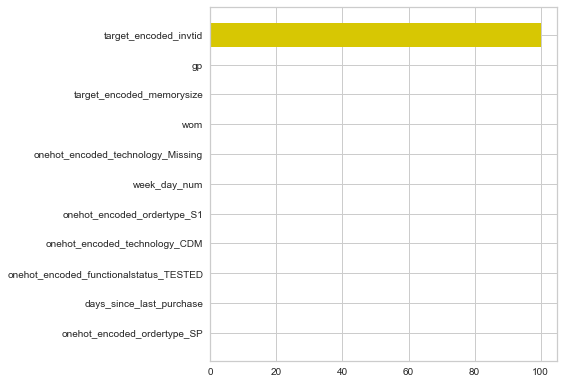

In [169]:
report_comparison.get_report()

https://drive.google.com/file/d/1rtwsrrE7GDVQ1i8K0abh_4ZdKBw7znHN/view?usp=sharing

### Best Fit Model

In [170]:
best_fit = mg.get_best_model(cfg)
best_fit.fit(x_train,y_train)
best_estimator=best_fit.best_estimator_.steps[0][1]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), estimator__alpha=0.5 
[CV]  estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), estimator__alpha=0.5, score=(train=-643.264, test=-657.547), total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), estimator__alpha=0.5 
[CV]  estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), estimator__alpha=0.5, score=(train=-630.824, test=-707.225), t

[CV]  estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), estimator__alpha=5, score=(train=-642.970, test=-717.173), total=   0.1s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s
[CV] estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), estimator__alpha=5 
[CV]  estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), estimator__alpha=5, score=(train=-667.858, test=-617.462), total=   0.1s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[CV] estimator=Lasso(alpha=1.0, c

[CV]  estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), estimator__max_depth=5, score=(train=-620.800, test=-651.692), total=  19.6s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  1.8min remaining:    0.0s
[CV] estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samp

#### score best fit

In [171]:
best_fit_report=me.RegressionReport(best_estimator)
best_fit_report.fit(x_train,y_train)
best_fit_report.score(x_test, y_test)

 99%|===================| 99/100 [03:18<00:02]        

#### best fit report 

In [ ]:
best_fit_report.get_report()

17 instances are over predictions
4 instances are under predictions
